# How hashtags and captions change the perception and position of your brand on Instagram??
 ## Using NLP to correlate the use of hashtags and captions for different fashion brands.


<div>
<img src="just.jpg" width="600"/>
</div>

Hashtags are tags linked through different platforms. A proper hashtag is a visual component of an ad that can be used across different social networks to promote continuity of a campaign. 

Brands usually care about hashtags because these can reinforce a brand's position and promote customers' familiarity with it, which has an impact in the early stages of the buying cycle. But can the use of hashtags (or captions) create an incorrect image of your brand? Let's say that you have a clothing brand in the category of designer, could the use of hashtags allude to another category of clothing? My goal is to use NLP to find how the use of captions and Instagram hashtags correlate across different brands and brand categories.

Data obtained from the project https://arxiv.org/abs/1704.04137. In their data project they obtained 24,752 Instagram posts by 13,350 people on Instagram. The data collection was done over a month period in January 2015. And in all the posts renowned fashion brand is named in the hashtags.

The data includes:
- Basic information of the posts (brand name, brand category, likes, comments, user id, followings, followers, captions, hashtags, and creation time).
- Learned features from their model (identifies the kind of picture). 
- Learned features from Microsoft emotion API (identifies the emotion of the people that appears in the picture)


### First step: installing all the packages and getting the data

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np 
from string import digits 
import spacy
import en_core_web_sm
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
%matplotlib inline

print('Loading words, spacy, punktd, stopwords')
nltk.download('words')
nlp = en_core_web_sm.load()
words = set(nltk.corpus.words.words())
nltk.download('stopwords')
nltk.download('punkt')
print('done, now loading text and basic formating of columns name')
# Read dataset and format texts 
df = pd.read_csv(r'fashion data on instagram.csv', index_col=0)

#Formating column and brand names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('-', '_').str.replace('?', '')
df.brandname = df.brandname.str.strip().str.lower().str.replace(' ', '_').str.replace('-', '_').str.replace('?', '')
df.brandcategory = df.brandcategory.str.strip().str.lower().str.replace(' ', '_').str.replace('-', '_').str.replace('?', '')
print('ready!!')
text_df=df[['brandcategory','hashtags','caption','brandname']]
text_df=text_df[~text_df['hashtags'].isnull()]  
text_df=text_df[~text_df['caption'].isnull()]  

Loading words, spacy, punktd, stopwords


[nltk_data] Downloading package words to
[nltk_data]     C:\Users\thalia\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\thalia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\thalia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


done, now loading text and basic formating of columns name
ready!!


### Cleaning the data and preparing for clustering:
My function cleaning is used to clean the text in a given column. Function tokenize also used.

After the data is cleaned. I used TDIFVectorizer to transform the text in a vector, with the frequencies of the words, that I will use for the cluster.

In [2]:
import re

def cleaning(frame,col):
    """ 
    Function to clean text from a column in a data frame 
  
    This funtion removes non alphabethic characters,stop words and numerical characters and return text in lowers. 
  
    Parameters: 
    Data frame, text column 
  
    Returns: 
    obj clean text from column
  
    """
    newframe=frame.copy()  
    newframe=newframe[~newframe[col].isnull()]   
    punc = ['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}','#',"%"]
    stop_words = text.ENGLISH_STOP_WORDS.union(punc)
    newframe[col]=newframe[col].str.replace('\d+', '').str.replace('\W', ' ').str.lower().str.replace(r'\b(\w{1,3})\b', '')
    newframe['Cleantext'] = [' '.join([w for w in x.lower().split() if w not in stop_words]) for x in newframe[col].tolist()] 
    newframe['Cleantext'] =[' '.join(word for word in x.lower().split() if not word.startswith('uf')if not word.startswith('ue')if not word.startswith('u0')) for x in newframe[col].tolist()] 
    content = newframe['Cleantext'].values
    return content

stemmer = SnowballStemmer('english')
tokenizer = RegexpTokenizer(r'[a-zA-Z\']+')

def tokenize(text):
    return [stemmer.stem(word) for word in tokenizer.tokenize(text)]

clean_hashtags=cleaning(text_df,'hashtags')
clean_caption=cleaning(text_df,'caption')

Now I will conver my text to a matrix of TF-IDF features using TDIFVectorizer.

In [3]:
vectorizing = TfidfVectorizer(sublinear_tf=True,  min_df=.08, norm='l2', max_features=500,
                              token_pattern=u'(?u)\b\w*[a-zA-Z]\w*\b',
                              encoding='latin-1', ngram_range=(1, 2), tokenizer = tokenize)

clean_hashtags_vector = vectorizing.fit_transform(clean_hashtags)
clean_caption_vector = vectorizing.fit_transform(clean_caption)

### Finding the number of clusters.

I created a function to plot the elbow method to find the optimum number of clusters.

In [4]:
def finding_k(vector,mink,maxk,step,atitle):
    """ 
    This function uses the elbow method to find the optimum number of clusters. 
  
    It calculates the Inertia (Sum of distances of samples to their closest cluster center) and plots it as
    function of k. 
  
    Parameters: 
    vector : Sample
    mink : min k value 
    maxk : max k value
    step : to go from kmin to kmax
    atitle : title for the plot
  
    Returns: elbow plot using matplotlib
  
    """
    sse = {}
    for k in range(mink, maxk, step):
        kmeans = KMeans(n_clusters=k, n_init = 10, max_iter=100,n_jobs = -1).fit(vector)
        text_df["clusters"] = kmeans.labels_
        sse[k] = kmeans.inertia_ # Inertiar
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.xlabel("Number of clusters")
    plt.ylabel("SSE")
    plt.title(atitle, fontsize=40)
    plt.show()

Plotting the elbow method for the different TDIFvectors

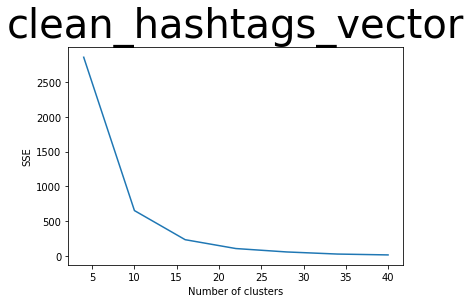

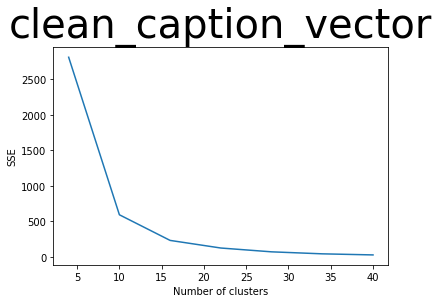

In [5]:
finding_k(clean_hashtags_vector,4,45,6,'clean_hashtags_vector')
finding_k(clean_caption_vector,4,45,6,'clean_caption_vector')

I found that for hashtags and captions, the best number of clusters is 15.
I created a function to plot the correlation between clusters and other columns in my data frame.

In [6]:
def plotclusterscorr(df,col_of_int,clustername):
    """
    This function plots correlation between clustes and a given column using matplot. 
  
    Parameters: 
    df : pandas data frame
    col_of_int (str) :string with the name of the column to correlate with clusters
    clustername (str): name of cluster to correlate
    Returns: plot using matplotlib
    """  
    clusters = df.groupby([clustername,col_of_int]).size()
    fig2, ax2 = plt.subplots(figsize = (10,8))
    sns.heatmap(clusters.unstack(level = col_of_int), ax = ax2, cmap = 'Blues')

    ax2.set_xlabel(col_of_int, fontdict = {'weight': 'bold', 'size': 2})
    ax2.set_ylabel(clustername, fontdict = {'weight': 'bold', 'size': 24})
    for label in ax2.get_xticklabels():
        label.set_size(12)
        label.set_weight("bold")
    for label in ax2.get_yticklabels():
        label.set_size(16)
        label.set_weight("bold")

#### First I'm going to get the clusters for the hashtags and captions and add the labels to the data frame

In [7]:
kmeans_caption = KMeans(n_clusters = 15, n_jobs = -1, max_iter=10, random_state=True, n_init=50)
kmeans_caption.fit(clean_caption_vector)
text_df['cluster_captions'] = kmeans_caption.labels_

kmeans_hashtags = KMeans(n_clusters = 15, n_jobs = -1, max_iter=10, random_state=True, n_init=50)
kmeans_hashtags.fit(clean_hashtags_vector)
text_df['cluster_hashtags'] = kmeans_hashtags.labels_


The correlation plot shows that cluster 1 for captions is highly correlated to the designer category. And high street and small couture are also correlated to this cluster. 
The mega couture category has low correlation with all the clusters.

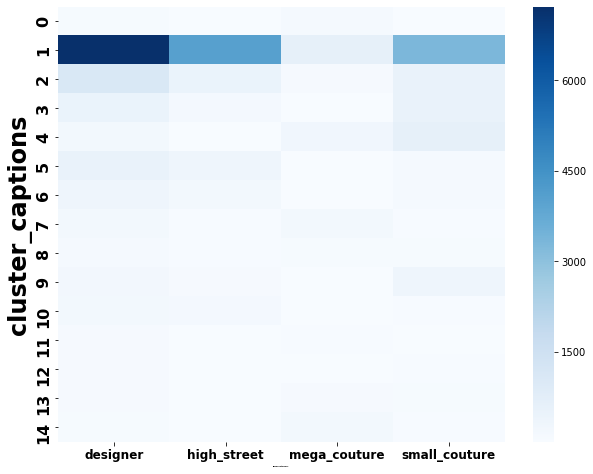

In [8]:
plotclusterscorr(text_df,'brandcategory','cluster_captions')

For the hashtags we saw the same pattern: 
    designer highly correlated to one cluster, high street and smallcouture also correlated to this cluster. Mega couture is not correlated to any cluster.

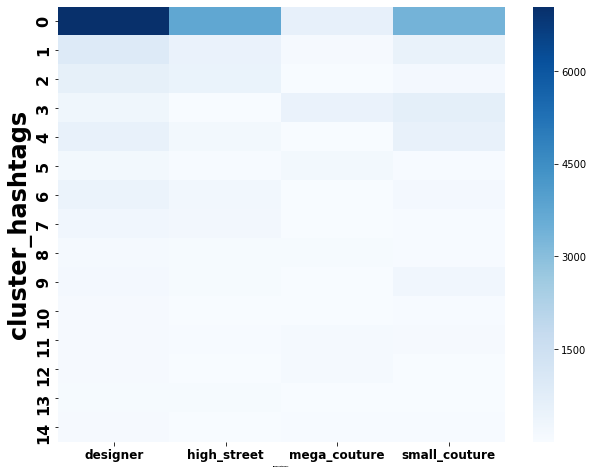

In [9]:
plotclusterscorr(text_df,'brandcategory','cluster_hashtags')

Plotting correlation for the brandnames for the differen cluster we found the same pattern:
-Most of the brands correlated to the cluster 1 in cpations and 0 in hashtags.

Except brioni, prada and lous vuitton that are correlated to other cluster.

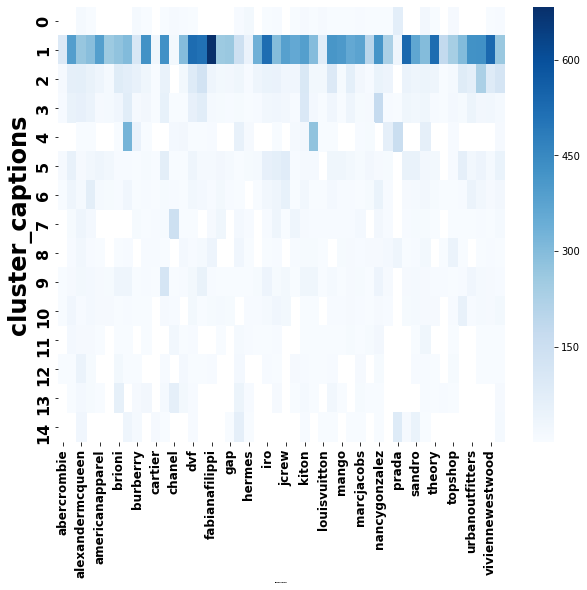

In [10]:
plotclusterscorr(text_df,'brandname','cluster_captions')

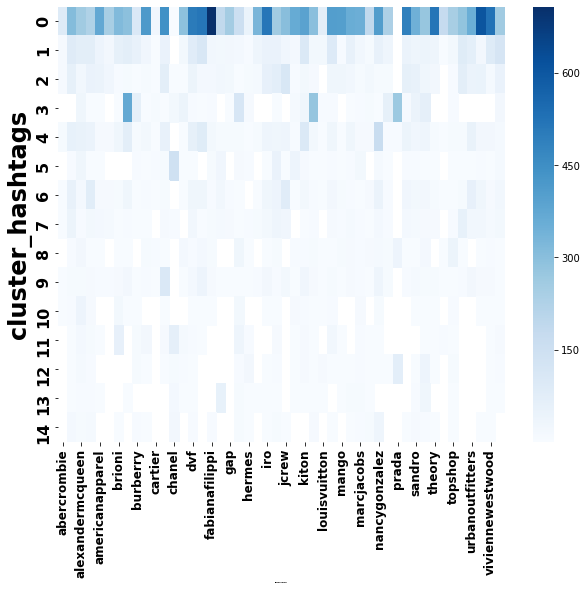

In [11]:
plotclusterscorr(text_df,'brandname','cluster_hashtags')

I can conclude that kmeans was not useful to analyze the hashtags and caption of the instagram posts. The code waas able to find cluster, but the cluster doesnt provide any information related to the categories and brand names.